In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('exchange_rate.csv', parse_dates=['date'])

In [5]:
data

date   Ex_rate
0    1990-01-01  0.785500
1    1990-02-01  0.781800
2    1990-03-01  0.786700
3    1990-04-01  0.786000
4    1990-05-01  0.784900
...         ...       ...
7583 2010-06-10  0.718494
7584 2010-07-10  0.721839
7585 2010-08-10  0.723197
7586 2010-09-10  0.720825
7587 2010-10-10  0.720825

[7588 rows x 2 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


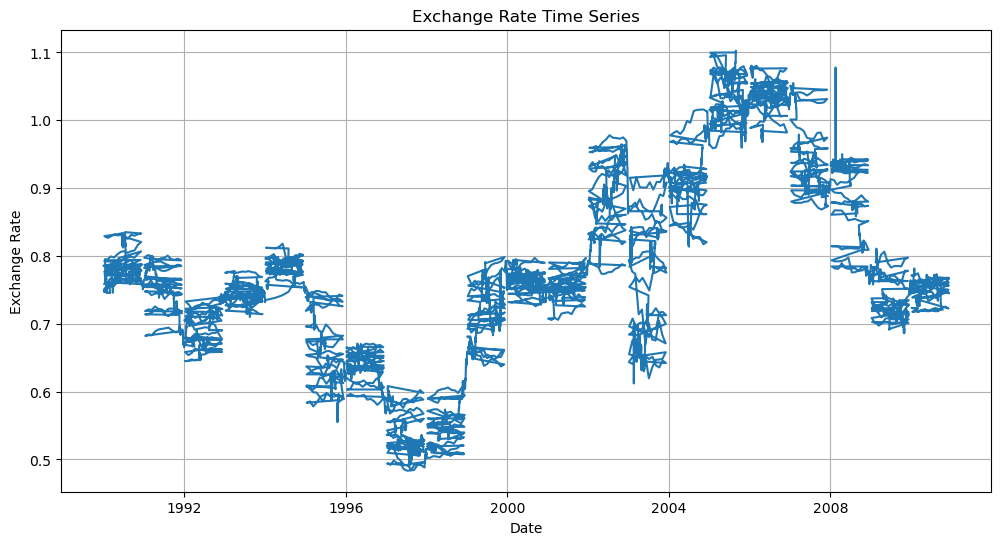

In [11]:
# Visualize the time series with more details
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'])
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)

In [7]:
# Example of handling outliers (using IQR method)
Q1 = data['Ex_rate'].quantile(0.25)
Q3 = data['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['Ex_rate'] >= lower_bound) & (data['Ex_rate'] <= upper_bound)]

In [8]:
#checking stationarity (using Augmented Dickey-Fuller test)
from statsmodels.tsa.stattools import adfuller

In [9]:
result = adfuller(data['Ex_rate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f"\t{key}: {value:.3f}")

ADF Statistic: -1.664994
p-value: 0.449233
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [10]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
# Set the 'date' column as the index
data.set_index('date', inplace=True)

In [13]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['Ex_rate'], ax=axes[0])
plot_pacf(data['Ex_rate'], ax=axes[1])
plt.show()

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Example parameters, replace with your estimated p, d, q values
p, d, q = 1, 1, 1


In [15]:
# Fit the ARIMA model
arima_model = ARIMA(data['Ex_rate'], order=(p, d, q))
arima_fit = arima_model.fit()

print(arima_fit.summary())

C:\Users\vinit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vinit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vinit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vinit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vinit\anaconda3\Lib\site-

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Fri, 02 Aug 2024   AIC                         -56102.322
Time:                        16:31:59   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

In [16]:
# Plot the residuals
residuals = arima_fit.resid
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

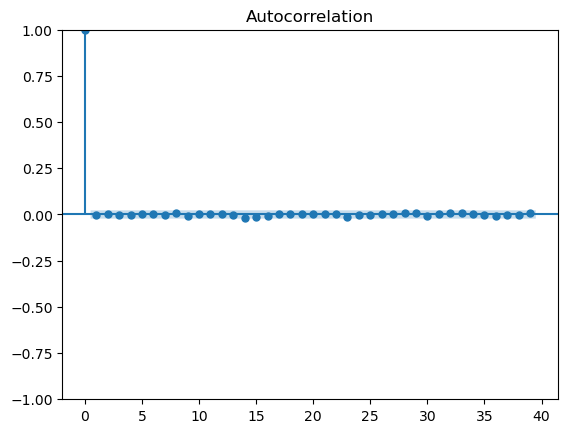

In [17]:
# ACF plot of residuals
plot_acf(residuals)
plt.show()

In [19]:
# Forecast
forecast_steps = 30  # Example: forecast 30 steps ahead
forecast = arima_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps+1, closed='right')
forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecast'])

C:\Users\vinit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\vinit\AppData\Local\Temp\ipykernel_13808\890228757.py:4: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps+1, closed='right')


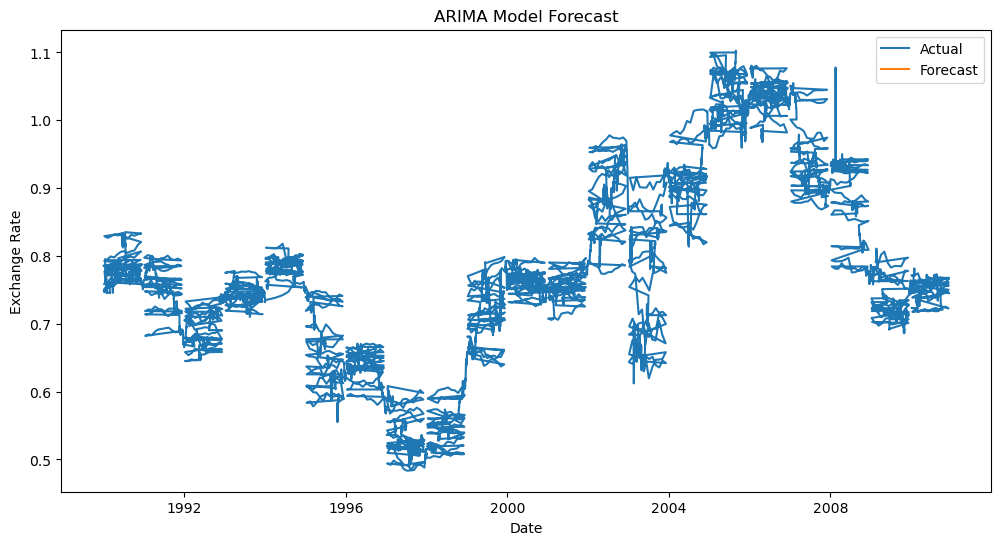

In [20]:
# Plot the actual values and forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='Actual')
plt.plot(forecast_df, label='Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the model
hw_model = ExponentialSmoothing(data['Ex_rate'], seasonal='add', seasonal_periods=12)
hw_fit = hw_model.fit()

print(hw_fit.summary())

C:\Users\vinit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\vinit\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77628.560
Trend:                             None   BIC                         -77531.480
Seasonal:                      Additive   AICC                        -77628.488
Seasonal Periods:                    12   Date:                 Fri, 02 Aug 2024
Box-Cox:                          False   Time:                         16:33:35
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8698356                alpha                 True
smoothing_seasonal       

In [25]:
import itertools
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

# Define a simpler parameter grid
param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [6, 12]  # Example periods
}

In [26]:
# Perform grid search
best_aic = float('inf')
best_params = None
warnings.filterwarnings("ignore")  # Ignore warnings from invalid parameter combinations

In [27]:
for trend, seasonal, seasonal_periods in itertools.product(*param_grid.values()):
    try:
        model = ExponentialSmoothing(exchange_rate_df['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        fit = model.fit()
        if fit.aic < best_aic:
            best_aic = fit.aic
            best_params = (trend, seasonal, seasonal_periods)
    except:
        continue

In [28]:
if best_params:
    print('Best parameters:', best_params)
else:
    print('No valid parameter combinations found.')

No valid parameter combinations found.


In [31]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [32]:
# Fit Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(data['Ex_rate']).fit()
ses_forecast = ses_model.forecast(steps=30)

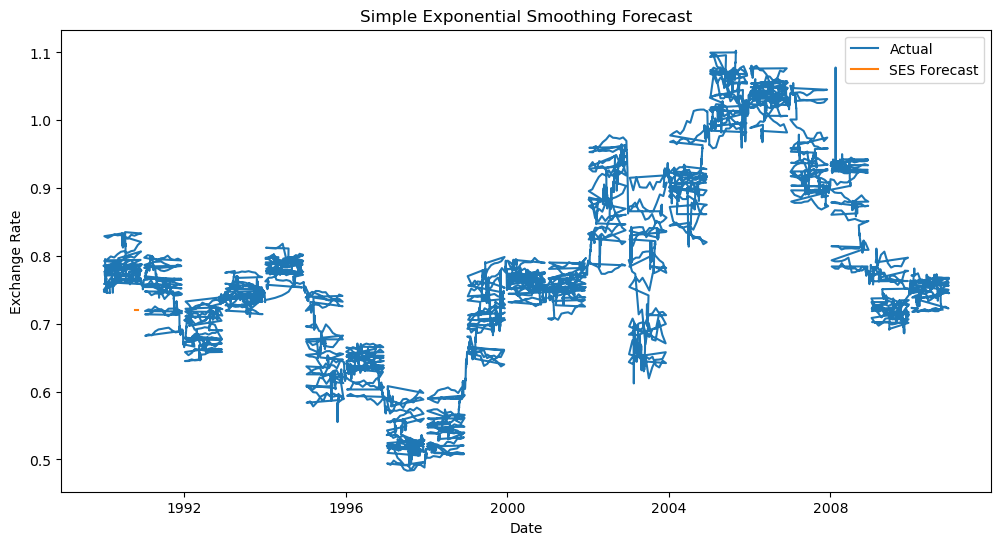

In [34]:
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='Actual')
plt.plot(ses_forecast, label='SES Forecast')
plt.title('Simple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

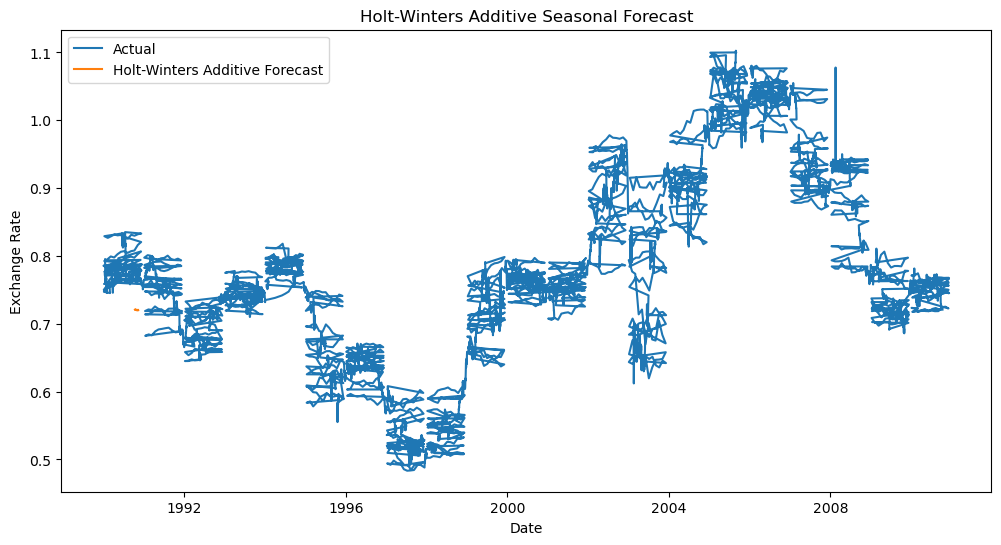

In [37]:
# Fit Holt-Winters Seasonal model with additive seasonality
try:
    hw_model_add = ExponentialSmoothing(data['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12).fit()
    hw_forecast_add = hw_model_add.forecast(steps=30)

    plt.figure(figsize=(12, 6))
    plt.plot(data['Ex_rate'], label='Actual')
    plt.plot(hw_forecast_add, label='Holt-Winters Additive Forecast')
    plt.title('Holt-Winters Additive Seasonal Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Additive Seasonal model failed: {e}")

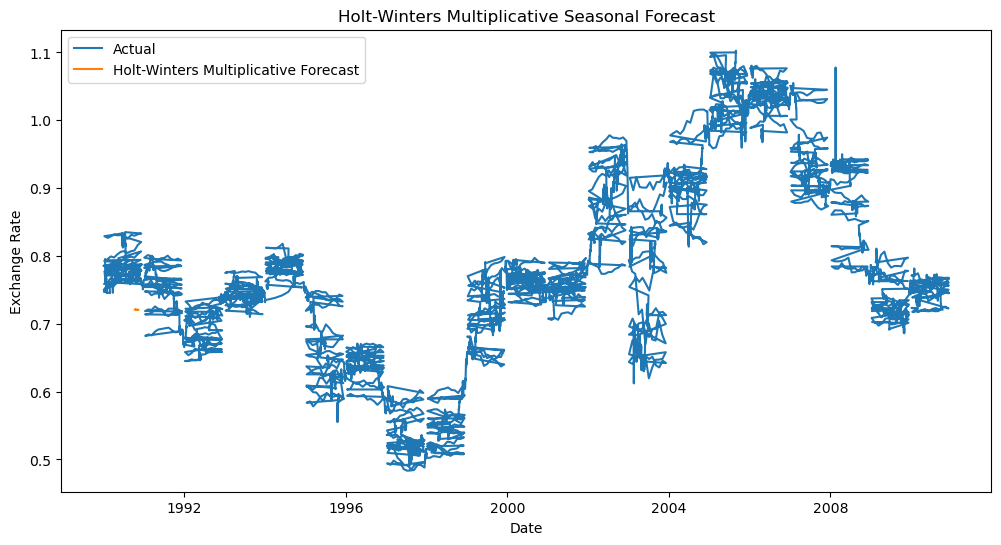

In [38]:

# Fit Holt-Winters Seasonal model with multiplicative seasonality
try:
    hw_model_mul = ExponentialSmoothing(data['Ex_rate'], trend='add', seasonal='mul', seasonal_periods=12).fit()
    hw_forecast_mul = hw_model_mul.forecast(steps=30)

    plt.figure(figsize=(12, 6))
    plt.plot(data['Ex_rate'], label='Actual')
    plt.plot(hw_forecast_mul, label='Holt-Winters Multiplicative Forecast')
    plt.title('Holt-Winters Multiplicative Seasonal Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Multiplicative Seasonal model failed: {e}")

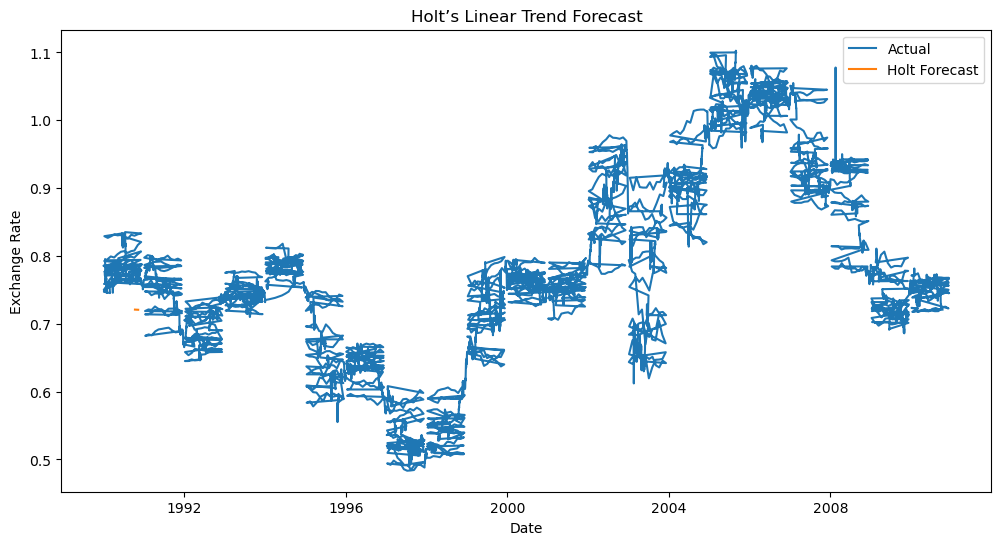

In [48]:
# Fit Holt’s Linear Trend model
holt_model = ExponentialSmoothing(data['Ex_rate'], trend='add').fit()
holt_forecast = holt_model.forecast(steps=30)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='Actual')
plt.plot(holt_forecast, label='Holt Forecast')
plt.title('Holt’s Linear Trend Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming we have the true values for the forecast period
# Replace this with your actual values
true_values = data['Ex_rate'][-30:]  # Example

In [42]:
# Evaluate Simple Exponential Smoothing
ses_mae = mean_absolute_error(true_values, ses_forecast)
ses_rmse = mean_squared_error(true_values, ses_forecast, squared=False)
ses_mape = (abs((true_values - ses_forecast) / true_values).mean()) * 100


In [43]:
print(f'Simple Exponential Smoothing - MAE: {ses_mae}, RMSE: {ses_rmse}, MAPE: {ses_mape}')

Simple Exponential Smoothing - MAE: 0.012707329121023495, RMSE: 0.016957663728794713, MAPE: nan


In [49]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
# Evaluate Holt’s Linear Trend
holt_mae = mean_absolute_error(true_values, holt_forecast)
holt_rmse = mean_squared_error(true_values, holt_forecast, squared=False)
holt_mape = (abs((true_values - holt_forecast) / true_values).mean()) * 100

In [50]:
print(f'Holt’s Linear Trend - MAE: {holt_mae}, RMSE: {holt_rmse}, MAPE: {holt_mape}')

Holt’s Linear Trend - MAE: 0.012755756156713368, RMSE: 0.017005229952751045, MAPE: nan
